# Feature selection

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, VarianceThreshold, chi2, RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
import category_encoders as ce
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from statsmodels import api as sm

n_cpu = multiprocessing.cpu_count()
n_cpu

16

In [2]:
def read_data(frac=0.02):
    dataframe = pd.read_csv('data/kickstarter.csv', parse_dates=['deadline', 'launched'])
    columns_to_drop_for_cleanup = ["category", "main_category", "country", "currency", "deadline", "launched", "name", "state"]
    
    # create new label by aggregating some of the possible choices
    dataframe = dataframe.assign(outcome=(dataframe['state'] == 'successful').astype(int))
    
    # cycling features handling and feature engineering on dates
    dataframe = dataframe[dataframe.launched != '1970-01-01 01:00:00']
    dataframe = dataframe.assign(
        launched_hour = dataframe.launched.dt.hour,
        launched_day = dataframe.launched.dt.day,
        launched_month = dataframe.launched.dt.month,
        launched_year = dataframe.launched.dt.year
    )
    dataframe['launched_hour_sin'] = np.sin(dataframe.launched_hour * (2. * np.pi/24))
    dataframe['launched_hour_cos'] = np.cos(dataframe.launched_hour * (2. * np.pi/24))
    dataframe['launched_month_sin'] = np.sin(dataframe.launched_month * (2. * np.pi/12))
    dataframe['launched_month_cos'] = np.cos(dataframe.launched_month * (2. * np.pi/12))
    dataframe["week_day"] = dataframe.launched.apply(lambda x: x.day_name())

    # categorical feature encoding
    label_encoding_columns = ["week_day"]
    label_encoder = ce.OrdinalEncoder(cols=label_encoding_columns)
    dataframe = label_encoder.fit_transform(dataframe)
    
    count_target_catboost_encoding_columns = ["category"]
    count_encoder = ce.CountEncoder()
    count_encoded = count_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns])
    dataframe = dataframe.join(count_encoded.add_suffix("_count"))
    target_encoder = ce.TargetEncoder(cols=count_target_catboost_encoding_columns)
    target_encoded = target_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns], dataframe["outcome"]) # normally fit on all and only do transform on the train set
    dataframe = dataframe.join(target_encoded.add_suffix("_target_encoded"))
    catboost_encoder = ce.CatBoostEncoder(cols=count_target_catboost_encoding_columns)
    catboost_encoded = catboost_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns], dataframe["outcome"])
    dataframe = dataframe.join(catboost_encoded.add_suffix("_catboost_encoded"))
    
    one_hot_encoding_columns = ["main_category", "currency", "country"] 
    one_hot_encoder = ce.OneHotEncoder(cols=one_hot_encoding_columns)
    dataframe = one_hot_encoder.fit_transform(dataframe)
    
    # cleanup
    dataframe.drop(columns=columns_to_drop_for_cleanup, axis=1, inplace=True, errors="ignore")
    
    return dataframe.dropna().sample(frac=1).reset_index(drop=True).sample(frac=frac)

## Remove features with low variance

For boolean features, variance can be found with $Var[X] = p(1-p)$ since they are Bernoulli random variables.

By default, removes all zero variance features.

In [3]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
286098,142017269,0,0,0,0,0,0,1,0,0,...,6,2014,-0.866025,0.500000,1.224647e-16,-1.000000e+00,7,1789,0.085523,0.095852
352448,1188961034,0,1,0,0,0,0,0,0,0,...,7,2012,-0.258819,-0.965926,-5.000000e-01,-8.660254e-01,1,10106,0.303780,0.309847
135580,1812451532,0,0,0,0,0,0,1,0,0,...,5,2015,-0.965926,0.258819,5.000000e-01,-8.660254e-01,2,14180,0.554725,0.559016
267301,1558519684,1,0,0,0,0,0,0,0,0,...,9,2013,0.000000,1.000000,-1.000000e+00,-1.836970e-16,3,9169,0.243538,0.248839
22145,1552103516,0,0,1,0,0,0,0,0,0,...,3,2012,-0.866025,0.500000,1.000000e+00,6.123234e-17,4,6758,0.517905,0.527379


In [4]:
original_df.shape

(7497, 72)

In [5]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [6]:
threshold = 0.8 * (1 - 0.8)

selector = VarianceThreshold(threshold=threshold)
df = selector.fit_transform(original_df[feature_cols], original_df['outcome'])

In [7]:
selected_features = pd.DataFrame(selector.inverse_transform(df), index=original_df.index, columns=feature_cols)
selected_features.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
286098,1.420173e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2014.0,-0.866025,0.500000,1.224647e-16,-1.000000e+00,7.0,1789.0,0.0,0.0
352448,1.188961e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,2012.0,-0.258819,-0.965926,-5.000000e-01,-8.660254e-01,1.0,10106.0,0.0,0.0
135580,1.812452e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,2015.0,-0.965926,0.258819,5.000000e-01,-8.660254e-01,2.0,14180.0,0.0,0.0
267301,1.558520e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2013.0,0.000000,1.000000,-1.000000e+00,-1.836970e-16,3.0,9169.0,0.0,0.0
22145,1.552104e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2012.0,-0.866025,0.500000,1.000000e+00,6.123234e-17,4.0,6758.0,0.0,0.0


In [8]:
selected_columns = selected_features.columns[selected_features.var() != 0]
original_df[selected_columns].head()

,ID,currency_2,goal,pledged,backers,country_2,usd pledged,usd_pledged_real,usd_goal_real,launched_hour,launched_day,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count
286098,142017269,1,50000.0,75.0,2,1,75.0,75.0,50000.0,20,1,6,2014,-0.866025,0.500000,1.224647e-16,-1.000000e+00,7,1789
352448,1188961034,1,4000.0,450.0,3,1,450.0,450.0,4000.0,13,24,7,2012,-0.258819,-0.965926,-5.000000e-01,-8.660254e-01,1,10106
135580,1812451532,1,45000.0,8055.0,154,1,8055.0,8055.0,45000.0,19,30,5,2015,-0.965926,0.258819,5.000000e-01,-8.660254e-01,2,14180
267301,1558519684,1,2100.0,50.0,2,1,50.0,50.0,2100.0,0,13,9,2013,0.000000,1.000000,-1.000000e+00,-1.836970e-16,3,9169
22145,1552103516,1,3500.0,3655.0,64,1,3655.0,3655.0,3500.0,20,5,3,2012,-0.866025,0.500000,1.000000e+00,6.123234e-17,4,6758


## Univariate Feature Selection

For each feature, measure how strongly the target depends on the feature using a statistical test like $X^2$ or ANOVA.

This is done one feature at a time.

In scikit learn, feature_selection.SelectKBest returns the K best features given some scoring function. We just need to decide the number of features we want to keep.

**SelectKBest should not be done on the validation and test set otherwise data leakage.**

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif

mutual_info_regression, mutual_info_classif, chi2 can handle sparse data without making it dense.

In [9]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
161472,1068265664,0,0,0,0,1,0,0,0,0,...,9,2016,-9.659258e-01,-0.258819,-1.000000e+00,-1.836970e-16,1,22314,0.356816,0.361273
100630,356911991,0,1,0,0,0,0,0,0,0,...,7,2015,5.000000e-01,-0.866025,-5.000000e-01,-8.660254e-01,6,2320,0.393103,0.384001
173430,952228299,0,1,0,0,0,0,0,0,0,...,2,2014,-9.659258e-01,0.258819,8.660254e-01,5.000000e-01,6,12357,0.540018,0.541026
64914,1791314910,0,0,0,0,0,0,1,0,0,...,6,2015,1.224647e-16,-1.000000,1.224647e-16,-1.000000e+00,4,11830,0.201691,0.206146
271344,380364054,0,0,0,0,0,0,0,0,0,...,2,2016,-7.071068e-01,0.707107,8.660254e-01,5.000000e-01,5,3663,0.329238,0.320014


In [10]:
original_df.shape

(7497, 72)

In [11]:
original_df.describe()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
count,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7.497000e+03,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000
mean,1.079359e+09,0.103241,0.175270,0.130319,0.059757,0.078298,0.020408,0.096172,0.026010,0.062425,...,6.481526,2014.241030,-0.235023,0.224232,-1.076918e-02,-4.454055e-02,3.762172,7575.317194,0.353122,0.354815
std,6.273074e+08,0.304294,0.380223,0.336676,0.237052,0.268658,0.141401,0.294846,0.159177,0.241942,...,3.341264,1.924587,0.693356,0.643320,7.106711e-01,7.021252e-01,1.908630,5914.924558,0.139316,0.139905
min,1.024208e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2009.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,13.000000,0.059574,0.050538
25%,5.317318e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,2013.000000,-0.866025,-0.258819,-8.660254e-01,-8.660254e-01,2.000000,2676.000000,0.255787,0.255328
50%,1.080637e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2014.000000,-0.500000,0.258819,1.224647e-16,-1.836970e-16,4.000000,6345.000000,0.348816,0.350316
75%,1.627288e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2016.000000,0.500000,0.866025,5.000000e-01,5.000000e-01,5.000000,11830.000000,0.410204,0.418632
max,2.147472e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,2018.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,7.000000,22314.000000,0.724638,0.721809


In [12]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [13]:
selector = SelectKBest(f_classif, k=5)
df = selector.fit_transform(original_df[feature_cols], original_df['outcome'])

/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [29 43 55] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [14]:
selected_features = pd.DataFrame(selector.inverse_transform(df), index=original_df.index, columns=feature_cols)
selected_features.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
161472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.356816,0.361273
100630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393103,0.384001
173430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.540018,0.541026
64914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201691,0.206146
271344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.329238,0.320014


In [15]:
selected_columns = selected_features.columns[selected_features.var() != 0]
original_df[selected_columns].head()

,pledged,backers,usd_pledged_real,category_target_encoded,category_catboost_encoded
161472,6696.0,74,6696.00,0.356816,0.361273
100630,2485.0,33,2485.00,0.393103,0.384001
173430,0.0,0,0.00,0.540018,0.541026
64914,3370.0,183,3801.68,0.201691,0.206146
271344,9256.0,52,9256.00,0.329238,0.320014


## Regularizations

L1 Regularization (Lasso) penalizes the absolute magnitude of the coefficients. As the strength of regularization is increased, features which are less important for predicting the target are set to 0 (also check LassoCV for cross validation and lasso regularization).

We can perform feature selection by adjusting the regularization parameter. We choose the parameter by finding the best performance on a hold-out set, or decide ahead of time how many features to keep.

C is the inverse of regularization strength, must be a positive float. smaller values specify strong regularization.

Not all solvers support L1 regularization.

* newton-cg: supports multi class problem, handles L2 and no penalty
* lbfgs: supports multi class problem, handles L2 and no penalty
* liblinear: good choice for small dataset, does not support multi class problem (only one versus rest), handles L1 penalty
* sag: good for large dataset, supports multi class problem, handles L2 and no penalty
* saga: good for large dataset, supports multi class problem, handles L1, L2, elasticnetand no penalty

L2 regularization (Ridge) penalizes the coefficients but don't make them reach 0 so this doesn't act as a feature selection method (also check RidgeCV for cross validation and ridge regularization).

In [16]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
203749,1524332079,0,1,0,0,0,0,0,0,0,...,6,2017,-1.000000,-1.836970e-16,1.224647e-16,-1.000000e+00,6,2541,0.268398,0.287978
39378,1490702658,0,0,0,0,0,0,0,0,1,...,10,2011,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,1,8554,0.255787,0.252958
157266,1055201018,0,0,0,0,0,0,0,0,0,...,3,2015,0.500000,8.660254e-01,1.000000e+00,6.123234e-17,3,2757,0.342764,0.291423
195574,732684821,0,0,0,0,0,0,0,0,0,...,8,2014,-0.866025,5.000000e-01,-8.660254e-01,-5.000000e-01,4,5153,0.085969,0.089090
192955,847610628,0,0,0,0,1,0,0,0,0,...,10,2013,-0.965926,-2.588190e-01,-8.660254e-01,5.000000e-01,6,22314,0.356816,0.357701


In [17]:
original_df.describe()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
count,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7.497000e+03,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000
mean,1.059107e+09,0.104175,0.163532,0.131786,0.062959,0.077098,0.025077,0.097906,0.027744,0.061891,...,6.450580,2014.254635,-0.240899,0.221402,-8.152832e-03,-4.936256e-02,3.763372,7565.805789,0.354781,0.356831
std,6.188560e+08,0.305508,0.369875,0.338281,0.242905,0.266764,0.156369,0.297207,0.164251,0.240974,...,3.330432,1.917206,0.687346,0.648555,7.127209e-01,6.997562e-01,1.881290,5887.073807,0.143686,0.144775
min,4.493690e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2009.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,49.000000,0.059574,0.027213
25%,5.149881e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,2013.000000,-0.866025,-0.258819,-8.660254e-01,-8.660254e-01,2.000000,2743.000000,0.255787,0.254601
50%,1.046296e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2014.000000,-0.500000,0.258819,1.224647e-16,-1.836970e-16,4.000000,6345.000000,0.348816,0.349809
75%,1.589784e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2016.000000,0.258819,0.866025,8.660254e-01,5.000000e-01,5.000000,11493.000000,0.436567,0.441769
max,2.147445e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,2018.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,7.000000,22314.000000,0.724638,0.805302


In [18]:
original_df.shape

(7497, 72)

In [19]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [20]:
X_train, X_test, y_train, y_test = train_test_split(original_df[feature_cols], original_df['outcome'], test_size=0.25, random_state=42)
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (5622, 71)
y train shape: (5622,)
X test shape: (1875, 71)
y test shape: (1875,)


In [21]:
standard_scaler = StandardScaler()

X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

In [22]:
C = [10, 1, .1, .001, .0001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='saga', max_iter=10_000, n_jobs=n_cpu)
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

C: 10
Coefficient of each feature: [[-4.47186171e-10 -9.81176555e-14 -4.89563294e-14  2.15150591e-13
  -1.75677600e-13 -5.59092615e-14 -9.69566321e-14 -1.24961707e-13
   8.30528310e-14 -1.69988270e-13  1.44500442e-13  6.72678891e-14
  -4.27294162e-14 -3.60400555e-13  6.18917864e-14 -2.78982926e-14
  -3.73313189e-14 -2.41149482e-13 -1.05649006e-13 -3.37444610e-14
  -1.73284439e-15 -1.69820900e-13 -2.53474839e-14 -5.14710460e-15
  -2.20305549e-15 -2.82381692e-15 -7.43688141e-15 -4.29027042e-16
   6.26068030e-15 -7.33175705e-16 -1.60591722e-07  8.19045619e-08
   9.51203912e-10 -3.73313189e-14 -2.41149482e-13 -1.05649006e-13
  -3.37444610e-14 -1.73284439e-15 -2.17966120e-14 -5.41976169e-14
  -1.23027909e-14 -2.53474839e-14 -2.22683086e-14  0.00000000e+00
  -5.14710460e-15 -2.05509991e-14 -2.80547389e-14 -2.20305549e-15
  -2.82381692e-15 -2.59099253e-15 -7.43688141e-15 -3.87401655e-15
  -4.29027042e-16 -1.39103029e-15  6.26068030e-15 -7.33175705e-16
   5.93464428e-08  7.81759365e-08 -1.3612

## Recursive Feature Elimination for feature selection

two important configuration options

* number of features to keep
* the algorithm used to help choose features

### For classification

In [23]:
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [24]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [25]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.888 (0.027)


In [26]:
pipeline.fit(X, y)
data = [[2.56999479,-0.13019997,3.16075093,-4.35936352,-1.61271951,-1.39352057,-2.48924933,-1.93094078,3.26130366,2.05692145]]
y_hat = pipeline.predict(data)
print('Predicted Class: %d' % (y_hat))

Predicted Class: 1


In [27]:
rfe.support_

array([False, False,  True,  True,  True, False,  True, False,  True,
       False])

In [28]:
rfe.ranking_

array([4, 5, 1, 1, 1, 6, 1, 2, 1, 3])

### For regression

In [29]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [30]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [31]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -27.267 (2.611)


In [32]:
pipeline.fit(X, y)
data = [[-2.02220122,0.31563495,0.82797464,-0.30620401,0.16003707,-1.44411381,0.87616892,-0.50446586,0.23009474,0.76201118]]
yhat = pipeline.predict(data)
print('Predicted: %.3f' % (yhat))

Predicted: -84.288


In [33]:
rfe.support_

array([False,  True, False, False,  True,  True,  True, False,  True,
       False])

In [34]:
rfe.ranking_

array([2, 1, 3, 4, 1, 1, 1, 5, 1, 6])

### RFE Hyperparameters

In [35]:
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y
 
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [36]:
X, y = get_dataset()
models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 0.718 (0.043)
>3 0.824 (0.035)
>4 0.877 (0.030)
>5 0.887 (0.032)
>6 0.890 (0.027)
>7 0.890 (0.024)
>8 0.882 (0.027)
>9 0.886 (0.026)


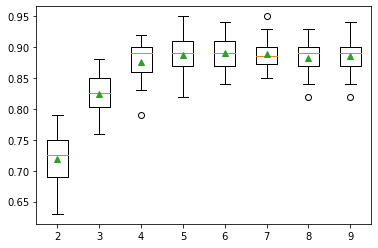

In [37]:
plt.boxplot(results, labels=names, showmeans=True);

## RFE internal algorithm

In [38]:
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
    return X, y
 
def get_models():
    models = dict()

    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['logi_reg'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['perceptron'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['dec_tree'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['rand_fo'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['grad_boos'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=n_cpu)
    return scores


In [39]:
X, y = get_dataset()
models = get_models()

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>logi_reg 0.888 (0.031)
>perceptron 0.845 (0.037)
>dec_tree 0.890 (0.032)
>rand_fo 0.857 (0.037)
>grad_boos 0.887 (0.034)


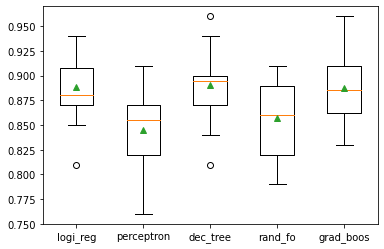

In [40]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Ordinary Least Squares

R squared is a value between 0 and 1, the closer to 1, the better the model is at explained data variance

Adjusted R squared penalizes the complexity of the model

In [41]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [42]:
X = df["petal_length"]
# add a constant (intercept) to show the difference R²
X = np.vander(X, 2)
y = df["petal_width"]
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            petal_width   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1882.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           4.68e-86
Time:                        22:06:33   Log-Likelihood:                 24.796
No. Observations:                 150   AIC:                            -45.59
Df Residuals:                     148   BIC:                            -39.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4158      0.010     43.387      0.000       0.397       0.435
const         -0.3631      0.040     -9.131      0.000      -0.442      -0.285
==============================================================================
Omnibus:                        5.765   Durbin-Watson:                   1.455
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.555
Skew:                           0.359   Prob(JB):                       0.0622
Kurtosis:                       3.611   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# remove the constant
X = df[["petal_length"]]
print(X.head())
y = df["petal_width"]
model = sm.OLS(y, X)
result = model.fit()
result.summary()

   petal_length
0           1.4
1           1.4
2           1.3
3           1.5
4           1.4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            petal_width   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              4417.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):                   1.22e-112
Time:                        22:06:33   Log-Likelihood:                         -8.7179
No. Observations:                 150   AIC:                                      19.44
Df Residuals:                     149   BIC:                                      22.45
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
petal_length     0.3365      0.005     66.463      0.000       0.327       0.347
==============================================================================
Omnibus:                       19.720   Durbin-Watson:                   0.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.498
Skew:                           0.957   Prob(JB):                     7.90e-06
Kurtosis:                       3.311   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""